In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from time import sleep
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [51]:
X = pd.read_csv("../Datasets/kobe.csv").dropna().reset_index()

minutes = X["minutes_remaining"].values
secondes = X["seconds_remaining"].values
temps_restant = pd.Series((minutes*60 + secondes), name="temps_restant")
X = pd.concat([X, temps_restant], axis=1)
y = X["shot_made_flag"]
X = X.drop(["shot_made_flag", "shot_id", 'team_id', "minutes_remaining", "seconds_remaining"], axis=1)
feature_names = np.array(X.columns)

In [52]:
# Fonction pour calculer les angles en degrés pour toutes les valeurs
def calculer_angles(x, y, distances_panier):
    # Calcul des angles en radians en utilisant l'arc tangente
    angles_radians = np.arctan2(y, x)
    
    # Correction des angles en tenant compte de la position du panier
    angles_radians += np.pi / 2  # Rajoute 90 degrés pour ajuster l'angle
    
    # Conversion en degrés
    angles_degrees = np.degrees(angles_radians)
    
    return angles_degrees
""" 
# Exemple d'utilisation avec des données
x = np.array([5, 10, 8])  # Exemple de coordonnées x
y = np.array([10, 15, 12])  # Exemple de coordonnées y
distances_panier = np.array([15, 20, 18])  # Exemple de distances au panier

angles = calculer_angles(x, y, distances_panier)
print("Les angles par rapport au panier sont :", angles, "degrés.") """


' \n# Exemple d\'utilisation avec des données\nx = np.array([5, 10, 8])  # Exemple de coordonnées x\ny = np.array([10, 15, 12])  # Exemple de coordonnées y\ndistances_panier = np.array([15, 20, 18])  # Exemple de distances au panier\n\nangles = calculer_angles(x, y, distances_panier)\nprint("Les angles par rapport au panier sont :", angles, "degrés.") '

In [41]:
def process_label(X):
    # Séparation des colonnes en variables quantitatives et catégorielles
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    
    # Standardisation des variables quantitatives
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    # Label Encoder pour les variables catégorielles
    for col in categorical_cols:
        label_encoder = LabelEncoder()
        X[col] = label_encoder.fit_transform(X[col])
    
    return X

In [42]:
def importance(X, y, feature_names):
    
    X_label = process_label(X)

    # Créer un modèle d'arbre de décision
    model = DecisionTreeClassifier()

    # Entraîner le modèle
    model.fit(X_label, y)

    # Afficher les variables les plus importantes
    importances = model.feature_importances_

    print("Variables selon leur importance :")
    for i in range(X.shape[1]):
        print(f"{i+1}. {feature_names[i]}: {importances[i]}")

    # Afficher l'arbre de décision
    g = sns.barplot(x=list(range(len(importances))),
            y=importances)

    g.set_xticks(range(len(feature_names)))
    g.set_xticklabels(feature_names, rotation=90, fontsize=8)

    return importances


In [65]:
def apprentissage(nom_modele, X, y, feature_names,seuil = 0.02):

    modele = {"knn": [KNeighborsClassifier, {'n_neighbors': range(1,101,10), 'weights': ['uniform', 'distance'], 'p': [1, 2]}],
              "logisticregression": [LogisticRegression, {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logisticregression__penalty': ['l1', 'l2']}],
              "decision_tree": [DecisionTreeClassifier, {"criterion": ["gini", "entropy", "log_loss"], "max_features": range(1, 10, 1), "max_depth": range(1, 10, 1)}],
              "random_forest": [RandomForestClassifier, {"n_estimators": range(1, 10, 5), "criterion": ["gini", "entropy"], "max_depth" : range(1,20,1)}],
              "gbayes": [GaussianNB, {}],
              "cbayes": [CategoricalNB, {'alpha': [0.1, 0.5, 1.0]}]
              }

    # Sélection des features numériques et catégorielles
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude=np.number)

    # Création des pipelines pour le prétraitement
    numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
    categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

    # Création du préprocesseur en combinant les pipelines numériques et catégoriels
    preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                           (categorical_pipeline, categorical_features))

    # Pipeline complet avec le préprocesseur et le classificateur
    if nom_modele =='logisticregression':
        pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=5000, solver="liblinear"))
    else:
        pipeline = make_pipeline(preprocessor, modele[nom_modele][0]())

    grid_search_cv = GridSearchCV(estimator=pipeline, param_grid=modele[nom_modele][1], cv=5, n_jobs=-1)  
    print(X.shape, y.shape)
    grid_search_cv.fit(X, y)
    best_params = {k.split("__")[-1]: v for k, v in grid_search_cv.best_params_.items()}
    print(f"Best score: {grid_search_cv.best_score_}")
    print(f"For parameters: {best_params}")

    importances = importance(X, y, feature_names)
    
    mask = importances > seuil
    sub_X = X.loc[:, mask] 
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(sub_X, y,test_size=0.2, random_state=0)

    if nom_modele == 'logisticregression':
        model_optimized = make_pipeline(preprocessor, LogisticRegression(solver="liblinear", max_iter=5000, **best_params))
    else:
        model_optimized = modele[nom_modele][0](**best_params)

    model_optimized.fit(X_train, y_train)    
    predictions= model_optimized.predict(X_test)
    print(classification_report(y_test, predictions))

In [66]:
def importance2(modele, nom_modele, model, best_params, X, y, seuil=0.02):

    modele_importance = {'logisticregression': logistic_importance(model, nom_modele),
                         'knn': knn_importance(model, nom_modele, X, y),
                         'decision_tree': tree_importance(model, nom_modele),
                         'random_forest': tree_importance(model, nom_modele),
                         'gbayes': gaussian_importance(model, nom_modele),
                         'cbayes': cbayes_importance(model, nom_modele),
                        }
    print("======= Top Features")
    print(len(modele_importance[nom_modele]), len(feature_names))
    score_feature_names = [feature_names[i] for i, importance in enumerate(modele_importance[nom_modele])]
    important_feature_names = [feature_names[i] for i, importance in enumerate(modele_importance[nom_modele]) if importance > seuil]
    print(f"Les variables les plus importantes pour la prise de décisions sont {important_feature_names}")
    
    mask = abs(modele_importance[nom_modele]) > seuil
    sub_X = X[:,mask]

    X_train, X_test, y_train, y_test = train_test_split(sub_X, y,test_size=0.2, random_state=0)
    if nom_modele == 'logisticregression':
        model_optimized = LogisticRegression(**best_params, solver="liblinear", max_iter=5000)
    else:
        model_optimized = modele[nom_modele][0](**best_params)

    model_optimized.fit(X_train, y_train)
    predictions= model_optimized.predict(X_test)
    print(classification_report(y_test, predictions))

In [67]:
def logistic_importance(model, nom):
    if nom == "logisticregression":
        logistic_model = model.named_steps['logisticregression']
        return logistic_model.coef_[0]  
    else:
        return 0

def cbayes_importance(model, nom):
    if nom == "cbayes":
        feature_log_prob = model.feature_log_prob_
        # Afficher l'importance relative des caractéristiques
        print("Log Probabilités conditionnelles par caractéristique et par classe:")
        for i, log_prob in enumerate(feature_log_prob):
            print(f"Classe {i}:")
            for j, prob in enumerate(log_prob.T):
                print(f"  Caractéristique {j}: {prob}")

        return np.var(feature_log_prob, axis=0)
    else:
        return 0
        
def tree_importance(model, nom):  
    if nom == "decision_tree" or nom == "random_forest":
        return model.feature_importances_
    else:
        return 0

def knn_importance(knn, nom, X, y):
    if nom == "knn":

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        feature_mask = np.zeros(X_train.shape[1], dtype=bool)
        best_score = 0.0

        # Itérer jusqu'à ce que toutes les caractéristiques soient examinées
        while not all(feature_mask):
            temp_best_score = best_score
            best_feature = None
            
            # Tester l'ajout de chaque caractéristique non sélectionnée
            for feature in range(X_train.shape[1]):
                if not feature_mask[feature]:
                    # Créer un nouveau masque pour l'essai actuel avec la caractéristique candidate incluse
                    trial_mask = feature_mask.copy()
                    trial_mask[feature] = True
                    
                    # Sélectionner les caractéristiques pour l'entraînement et le test
                    X_train_selected = X_train[:, trial_mask]
                    X_test_selected = X_test[:, trial_mask]

                    knn.fit(X_train_selected, y_train)
                    y_pred = knn.predict(X_test_selected)
                    score = accuracy_score(y_test, y_pred)
                    
                    # Mettre à jour le meilleur score et la meilleure caractéristique
                    if score > temp_best_score:
                        temp_best_score = score
                        best_feature = feature
            
            # Vérifier si une caractéristique améliorant le score a été trouvée
            if best_feature is not None and temp_best_score > best_score:
                best_score = temp_best_score
                feature_mask[best_feature] = True
                print(f"Caractéristique {best_feature} ajoutée avec un score de {best_score}")
            else:
                # Arrêter si l'ajout de nouvelles caractéristiques n'améliore pas le score
                break

        return feature_mask
    else:
        return 0

def gaussian_importance(gaussian_nb, nom):
    if nom == "gbayes":
        means = gaussian_nb.theta_
        variances = gaussian_nb.var_
        return np.abs(means[1] - means[0]) / np.sqrt(variances[0] + variances[1])
    else:
        return 0

(25697, 22) (25697,)
Best score: 0.601393464034472
For parameters: {'C': 0.1, 'penalty': 'l1'}
Variables selon leur importance :
1. index: 0.07640612720784792
2. action_type: 0.13075162049656602
3. combined_shot_type: 0.008403791061228912
4. game_event_id: 0.12768969106855674
5. game_id: 0.04512151424403606
6. lat: 0.04646585802892242
7. loc_x: 0.05069602120889363
8. loc_y: 0.04348972360720389
9. lon: 0.05400157580706085
10. period: 0.011898804254510854
11. playoffs: 0.002136265609907925
12. season: 0.01828725055518055
13. shot_distance: 0.04137638122916527
14. shot_type: 0.0013993539849512413
15. shot_zone_area: 0.0075737361461125025
16. shot_zone_basic: 0.003256202546774462
17. shot_zone_range: 0.0036672527124618545
18. team_name: 0.0
19. game_date: 0.07448116839657898
20. matchup: 0.06676972959691914
21. opponent: 0.04981689608973956
22. temps_restant: 0.1363110361473812
              precision    recall  f1-score   support

         0.0       0.61      0.73      0.67      2866
    

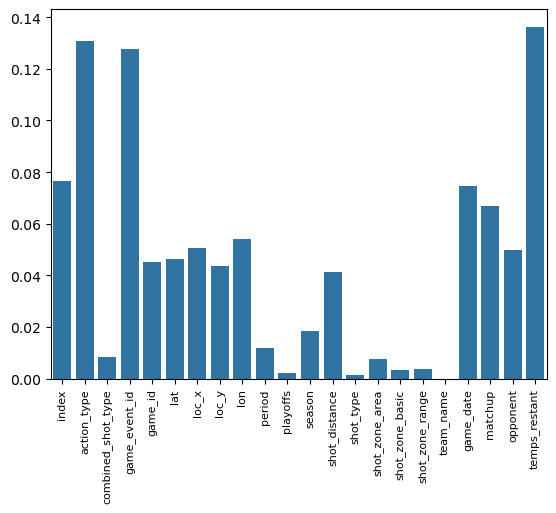

In [68]:
apprentissage("logisticregression", X, y, feature_names, 0.02)

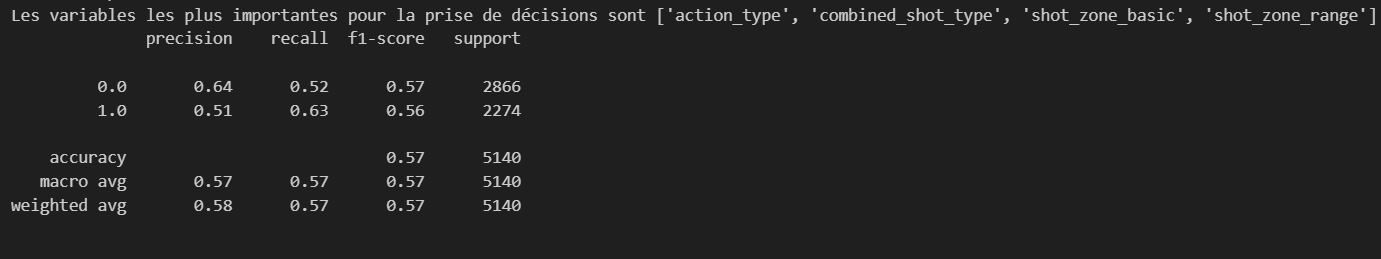

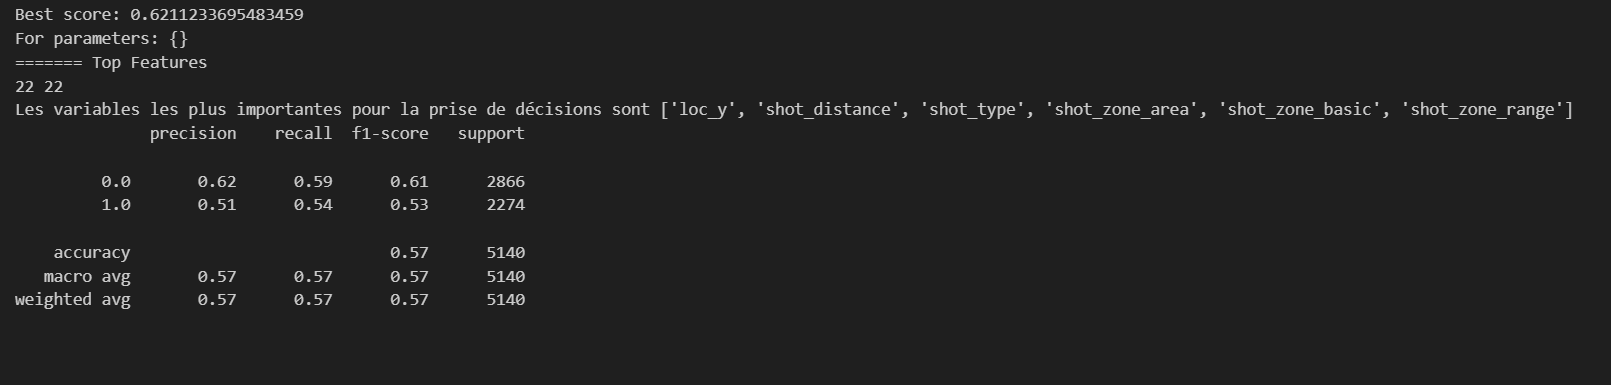

In [1]:
liste = [1, 2 , 3, 4, 5, 6 ,7 ,8 ,9]
liste[:-1]

[1, 2, 3, 4, 5, 6, 7, 8]